## **데이콘 뉴스 기사 레이블 복구 해커톤**

본 프로젝트는 뉴스 데이터셋의 'category'필드를 복구하는 것을 목적으로 한다.  
데이터셋은 6개의 카테고리로 분류되어야 하며, 6만 행으로 이루어진 csv 파일이다. 파일에는 'id'와 'text'필드만 있다.  
복구해야 하는 카테고리 종류는 다음과 같다.  
0: Business  
1: Entertainment  
2: Politics  
3: Sports  
4: Tech  
5: World


-------------------
Dataset Info.  
news.csv  
id : 샘플 고유 id  
title : 뉴스 기사 제목  
content : 뉴스 기사 전문  

In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep 26 18:30:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import re
import numpy as np
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import FastText
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

In [2]:
df = pd.read_csv('news.csv')

In [3]:
df

,id,title,contents
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Lui...
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often a..."
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks A...,Yasmine Hamdan performs 'Hal' which she also s...
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of ...
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qu...
...,...,...,...
59995,NEWS_59995,"Dolphins Break Through, Rip Rams For First Win",But that #39;s OK. Because after a 31-14 rout ...
59996,NEWS_59996,"After Steep Drop, Price of Oil Rises",The freefall in oil prices ended Monday on a s...
59997,NEWS_59997,Pro football: Culpepper puts on a show,To say Daunte Culpepper was a little frustrate...
59998,NEWS_59998,Albertsons on the Rebound,The No. 2 grocer reports double-digit gains in...


In [4]:
df['text'] = df['title'] + ' ' + df['contents']

In [5]:
df.head()

,id,title,contents,text
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Lui...,Spanish coach facing action in race row MADRID...
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often a...","Bruce Lee statue for divided city In Bosnia, w..."
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks A...,Yasmine Hamdan performs 'Hal' which she also s...,Only Lovers Left Alive's Tilda Swinton Talks A...
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of ...,Macromedia contributes to eBay Stores Macromed...
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qu...,Qualcomm plans to phone it in on cellular repa...


In [6]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
# 데이터 전처리 함수 정의
def preprocessing(text):
    # URL 제거
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text, flags=re.MULTILINE)

    # 이모지 제거
    text = text.encode('ascii', 'ignore').decode('ascii')

    # 'short_description' 제거
    text = text.replace('short_description', '')

    # 소문자 변환, 특수문자 제거
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    # 한 글자 제거
    text = ' '.join([word for word in text.split() if len(word) > 1])

    # 숫자 제거
    text = re.sub(r'\d+', '', text)

    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    text = ' '.join([lemmatizer.lemmatize(word) for word in words])

    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])

    return text

In [9]:
sample_text = 'Blake Leeper may be training for the Rio 2016 Olympic Games but he found time to stop by the Samsung Smart Lounge to talk about his goals and how technology can help people like him compete at a high level.'
result = preprocessing(sample_text)
result

'blake leeper may training rio olympic game found time stop samsung smart lounge talk goal technology help people like compete high level'

In [10]:
df['preprocessed_text'] = df['text'].apply(preprocessing)

In [11]:
df['preprocessed_text'].head()

0    spanish coach facing action race row madrid af...
1    bruce lee statue divided city bosnia one man h...
2    lover left alives tilda swinton talk almost qu...
3    macromedia contributes ebay store macromedia h...
4    qualcomm plan phone cellular repair overtheair...
Name: preprocessed_text, dtype: object

In [12]:
# SpaCy 영어 모델 로드
nlp = spacy.load("en_core_web_sm")

# to list
documents = df['preprocessed_text'].tolist()

def spacy_tokenizer(text):
    tokens = nlp(text)
    return [token.text for token in tokens if not token.is_space]

tqdm_documents = tqdm(documents, desc="Tokenizing..")
documents = [spacy_tokenizer(text) for text in tqdm_documents]

Tokenizing..: 100%|██████████| 60000/60000 [10:01<00:00, 99.75it/s] 


In [13]:
SEED = 1028

# 랜덤 시드 설정
np.random.seed(SEED)

In [15]:
# FastText for vectorization
model = FastText(sentences=documents, vector_size=100, window=5, min_count=3, sg=1, epochs=10)

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform([" ".join(tokens) for tokens in documents])

# FastText 모델로 텍스트 벡터 추출
text_vectors = [model.wv[word] if word in model.wv else [0] * 100 for word in tfidf_vectorizer.get_feature_names_out()]

# TF-IDF 가중치를 곱하여 최종 벡터 생성
final_vectors = tfidf_matrix.dot(text_vectors)

# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(final_vectors)

In [ ]:
"""
def train_fasttext_model(df, text, vector_size=100, window=5, min_count=3, sg=1, epochs=10):
    # 텍스트 데이터 추출
    sentences = df[text].apply(str.split).tolist()

    # FastText 모델 학습
    model = FastText(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, sg=sg, epochs=epochs)

    # 학습된 모델 저장
    model.save("fasttext_model.model")

    return model

# 학습 데이터로 FastText 모델 학습
model = train_fasttext_model(df, text='preprocessed_text')
"""

In [17]:
# K-Means 클러스터링
clustering_model = KMeans(n_clusters=6, random_state=SEED)
df['kmeans_cluster'] = clustering_model.fit_predict(df_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


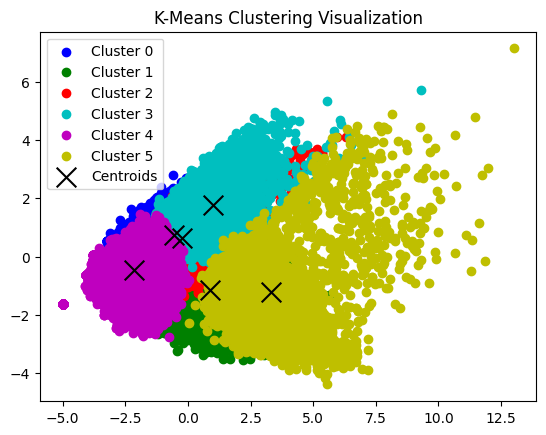

In [19]:
num_clusters = 6
cluster_labels = df['kmeans_cluster']

# 데이터를 2차원으로 축소 (PCA 사용)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_embeddings)

# 각 클러스터 색상 지정
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# 클러스터 시각화
for cluster_num in range(num_clusters):
    cluster_data = reduced_data[cluster_labels == cluster_num]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[cluster_num], label=f'Cluster {cluster_num}')

# 클러스터 중심 시각화
cluster_centers = pca.transform(clustering_model.cluster_centers_)
# X좌표, y좌표
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='k', marker='x', s=200, label='Centroids')

plt.title('K-Means Clustering Visualization')
plt.legend()
plt.show()

In [20]:
# 각 클러스터의 데이터 개수
cluster_counts = df['kmeans_cluster'].value_counts()
print(cluster_counts)

1    13295
4    13211
2    11337
0     9357
3     7742
5     5058
Name: kmeans_cluster, dtype: int64


0: Business  
1: Entertainment  
2: Politics  
3: Sports  
4: Tech  
5: World

## 0 -> 2: Politics

In [23]:
df[df['kmeans_cluster'] == 0]['text'].head(20)

8     Obama Marks Anniversary Of 9/11 Attacks With M...
9     Republican Congressman Says Trump Should Apolo...
11    Kerry rolls out tax-cut plan for middle class ...
12    Read Live Updates From The South Carolina Demo...
14    Obama Administration Helps Wall Street Crimina...
15    It's Not As Easy As You Think To Spot A Gerrym...
17    Parents Of School Shooting Victims Decry 'Moro...
18    A Fair Way to Choose Candidates for Republican...
19    Congress Spikes Handout For Private Equity aut...
32    Sunday Show Hosts Hit Back On Trump Administra...
35    Is E-Voting Secure? (CBS) Nearly one third of ...
36    Agencies Postpone Issuing New Rules Until Afte...
45    The Trouble with Broadcasting in a Social Worl...
47    Bush author says White House applying pressure...
53    These Are The People Putting Up Money To Stop ...
54    Trump Says U.S. 'Not Going To Look Foolish As ...
55    Florida Shooting Survivors Confront Lawmakers ...
58    Democrats Plan Big Anti-Corruption Theme F

## 1 -> 4: Tech

In [25]:
df[df['kmeans_cluster'] == 1]['text'].head(20)

3      Macromedia contributes to eBay Stores Macromed...
7      Bump Stock Maker Resumes Sales One Month After...
23     FTC Files First Lawsuit Against Spyware Concer...
31     Sony PSP Draws Crowds and Lines on First Day (...
37     Deep Impact Space Probe Aims to Slam Into Come...
41     Photos from MacExpo 2004 With over 100 exhibit...
49     Bribery Considered, Halliburton Notes Suggest ...
50     UN Predicts Boom In Robot Labor The use of rob...
73     Delphi, XM Unveil Handheld Satellite Radio Rec...
74     2 Russian Officials Charged In Massive Yahoo H...
79     Suit by Cities Says Microsoft Overcharged icro...
83     IT Product Guide goes beta InfoWorld and Open ...
93     Oracle wins PeopleSoft takeover case The long-...
100    GM, DaimlerChrysler to develop hybrid engines ...
103    Nortel attempts to calm fears of possible stoc...
113    Coal Companies Paid Lobbyists Millions Before ...
119    Microsoft, Cisco: Seeing Eye-to-Eye on Network...
120    BA cancels 1,000 Heathro

## 2 -> 3: Sports

In [26]:
df[df['kmeans_cluster'] == 2]['text'].head(30)

0      Spanish coach facing action in race row MADRID...
2      Only Lovers Left Alive's Tilda Swinton Talks A...
13     GAME DAY PREVIEW Game time: 6:00 PM CHARLOTTE,...
16     Fischer's Fiancee: Marriage Plans Genuine (AP)...
21     Blake Leeper Wants to Be the First American Pa...
22     College Basketball: Georgia Tech, UConn Win AT...
26     Doping case was flawed, report finds MONTREAL ...
30     Montgomerie Beats Woods in S. Korean Skins (AP...
38     Longhorns Rip Cowboys Cedric Benson scores fiv...
39     Ricky Williams ordered to repay Dolphins Forme...
40     Out for V-I-C-T-O-R-Y, but Missing Tiles Missi...
42     Thomas out of Six Nations Wales captain Gareth...
43     Tavarez Breaks Hand After Leaving Game 4 (AP) ...
44     Golf: Cink in command in winning NEC Invitatio...
46     Official: Cuper Signs With Mallorca Hector Cup...
48     Stove burns hot in Seattle The Mariners, who a...
88     Expos Skipper Robinson OKs One-Year Deal (AP) ...
94     Jordan: Ford decision wa

## 3 -> 5: World

In [27]:
df[df['kmeans_cluster'] == 3]['text'].head(20)

29     Israel Kills 3 Palestinians in Big Gaza Incurs...
34     The Folly of the Sole Superpower Writ Small au...
56     Sadr #39;s aide denies entering of Iraqi polic...
57     Former Nazi Guard Loses Canadian Court Ruling ...
59     Afghanistan Death Toll in 2004 Up to 957 KANDA...
60     Portugal PM, Cabinet Submit Resignations LISBO...
61     Typhoon-Like Gusts Hit Japan; 13 Injured TOKYO...
63     Family appeals for release of UK hostage The f...
69     Fallujah situation  #39;disastrous #39;, chari...
71     Germany Extends Afghan Mission The German Parl...
75     Report Expected to Blame 24 in Iraq Abuse WASH...
77     Poland to Cut One-Third of Its Troops in Iraq ...
78     Burundi Agrees to Move Tutsi Refugees to Safet...
82     Australia investigating if Iraq body could be ...
86     Colombian militia leader dead Bogota, Colombia...
87     New Iraq mission for Black Watch Troops from t...
90     Three Palestinians killed in Rafah; Palestinia...
95     Turkish PM eyes  #39;pos

## 4 -> 1: Entertainment

In [31]:
df[df['kmeans_cluster'] == 4]['text'].head(30)

1      Bruce Lee statue for divided city In Bosnia, w...
4      Qualcomm plans to phone it in on cellular repa...
5      Thomson to Back Both Blu-ray and HD-DVD Compan...
6      Time to Talk Baseball It's time to talk about ...
10     Harry #39;s argy-bargy PRINCE Charles has aske...
20     Deere's Color Is Green With big tractors, big ...
24     Kentucky Fan Gets National Champs Tattoo. Let'...
25     Be on TOP //www.huffingtonpost.com/entry/be-on...
28     Cate Blanchett Set To Star As Lucille Ball In ...
33     Memo To EPA Chief Pruitt //www.huffingtonpost....
52     Amazon's Next Kindle May Have Better Battery L...
62     John Waters' Women at the Film Society of Linc...
64     Jon Voight Is 'Concerned' About Daughter Angel...
67     Fan Picks Nose Behind TNT Broadcast Crew Winks...
68     Satire Will Not Save Us //www.huffingtonpost.c...
72     Up to the Challenge The Redskins contend that ...
76     WATCH //www.huffingtonpost.com/entry/perrish-c...
80     Robert Redford Sidesteps

In [33]:
# Entertianment가 조금 더 많이 차지
print(df['text'][1]) # Entertainment
print(df['text'][4]) # Tech
print(df['text'][10]) # World
print(df['text'][62]) # Entertainment
print(df['text'][67]) # Entertainment
print(df['text'][72]) # Sports
print(df['text'][84]) # Entertainment
print(df['text'][135]) # Politics

Bruce Lee statue for divided city In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.
Qualcomm plans to phone it in on cellular repairs Over-the-air fixes for cell phones comes to Qualcomm's CDMA.
Harry #39;s argy-bargy PRINCE Charles has asked Scotland Yard for an in-depth report on his son Harry #39;s trip to Argentina after reports of excessive drinking and a kidnap plot.
John Waters' Women at the Film Society of Lincoln Center authors No one missed the irony of a John Waters retrospective at The Walter Reade Theater across Lincoln Center's plaza from Fashion Week.
Fan Picks Nose Behind TNT Broadcast Crew Winks At Camera (VIDEO) authors By Joe Lucia Awful Announcing During Thursday's Trail Blazers-Knicks game on TNT this fan sitting behind TNT's broadcast
Up to the Challenge The Redskins contend that last week's debacle in the secondary agains

## 5 -> 0: Business

In [35]:
df[df['kmeans_cluster'] == 5]['text'].head(20)

27     Kmart-Sears merger about price, quality Averag...
51     Oil Falls Below \$49 on Nigeria Cease-Fire LON...
70     ABN Amro Profit Rises, Buoyed by Sale of Asia ...
85     Stocks to Open Higher on Growth Outlook NEW YO...
98     Producer Prices Up 0.1 Pct, Energy Drops (Reut...
99     Rigel, Merck Form Development Partnership NEW ...
110    Lan switch sales looking good for 2004 Despite...
111    Oil rallies to new record high Crude oil futur...
124    Tuesday Morning Lowers 2004 Guidance Home acce...
140    Durable Goods, Housing Data Trip Stocks NEW YO...
161    NYSE probing late trading for price manipulati...
183    Boston Scientific #39;s Taxus Sales Rebounded ...
190    China to lead recovey in air travel industry G...
196    Qantas Not Lifting Fuel Surcharge On Tickets -...
251    DAILY DIGEST With time running out and its fut...
284    Stocks Climb on Positive GDP Figure News NEW Y...
290    Intel Raises 4th-Quarter Sales Forecast Intel ...
296    News deal paves way for 

In [36]:
# 대체로 Business 내용
print(df['text'][27]) # Business
print(df['text'][99]) # Business
print(df['text'][110]) # Business
print(df['text'][124]) # Business
print(df['text'][161]) # Business
print(df['text'][251]) # Business
print(df['text'][290]) # Business
print(df['text'][316]) # Entertainment
print(df['text'][320]) # Business

Kmart-Sears merger about price, quality Average customers know the same thing that ministers of high finance understand: It #39;s all about the price. Shoppers Thursday at the Billings Sears store were eager to find out what a proposed
Rigel, Merck Form Development Partnership NEW YORK (Reuters) - Biotechnology company Rigel  Pharmaceuticals Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=RIGL.O target=/stocks/quickinfo/fullquote"&gt;RIGL.O&lt;/A&gt; has entered into a collaboration  pact with drugmaker Merck   Co. Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=MRK.N target=/stocks/quickinfo/fullquote"&gt;MRK.N&lt;/A&gt; to find treatments  for cancer and potentially other diseases, Rigel said on  Monday.
Lan switch sales looking good for 2004 Despite a decline of two per cent in the second quarter of 2004, the global market for local area network (Lan) switches remains up 23 per cent year over year, the latest market research from IDC has

In [37]:
mapping_dict = {
    0: 2,
    1: 4,
    2: 3,
    3: 5,
    4: 1,
    5: 0
}

In [38]:
df['mapping'] = df['kmeans_cluster'].apply(lambda x: mapping_dict[x])

In [39]:
result_df = pd.read_csv('sample_submission.csv')

In [40]:
result_df['category'] = df['mapping'].values

In [41]:
result_df['category'].head(20)

0     3
1     1
2     3
3     4
4     1
5     1
6     1
7     4
8     2
9     2
10    1
11    2
12    2
13    3
14    2
15    2
16    3
17    2
18    2
19    2
Name: category, dtype: int64

In [42]:
result_df.to_csv('result_submission.csv', index=False)